<a href="https://colab.research.google.com/github/thanhlong1997/100-nlp-papers/blob/master/auto%20correct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

# tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

2.3.0


In [85]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [86]:
with open('/content/data_noise.txt','r',encoding='utf-8') as file:
  data_noise = file.read().split('\n')
with open('/content/data_true.txt','r',encoding='utf-8') as file:
  data_true = file.read().split('\n')

In [87]:
def unfold_vnese(token):
    accent_dictionary = {
    'á':'as', 'à':'af', 'ả':'ar', 'ã':'ax', 'ạ':'aj', 'â':'aa', 'ấ':'aas', 'ầ':'aaf', 'ẩ':'aar', 'ẫ':'aax', 'ậ':'aaj', 'ă':'aw', 'ắ':'aws', 'ằ':'awf', 'ẳ':'awr', 'ẵ':'awx', 'ặ':'awj',
    'ó':'os', 'ò':'of', 'ỏ':'or', 'õ':'ox', 'ọ':'oj', 'ô':'oo', 'ố':'oos', 'ồ':'oof', 'ổ':'oor', 'ỗ':'oox', 'ộ':'ooj', 'ơ':'ow', 'ớ':'ows', 'ờ':'owf', 'ở':'owr', 'ỡ':'owx', 'ợ':'owj',
    'é':'es', 'è':'ef', 'ẻ':'er', 'ẽ':'ex', 'ẹ':'ej', 'ê':'ee', 'ế':'ees', 'ề':'eef', 'ể':'eer', 'ễ':'eex', 'ệ':'eej',
    'ú':'us', 'ù':'uf', 'ủ':'ur', 'ũ':'ux', 'ụ':'uj', 'ư':'uw', 'ứ':'uws', 'ừ':'uwf', 'ử':'uwr', 'ữ':'uwx', 'ự':'uwj',
    'í':'is', 'ì':'if', 'ỉ':'ir', 'ĩ':'ix', 'ị':'ij',
    'ý':'ys', 'ỳ':'yf', 'ỷ':'yr', 'ỹ':'yx', 'ỵ':'yj',
    'đ':'dd'
    }
    unfold = ''
    for character in token :
        if character in accent_dictionary.keys():
            unfold += accent_dictionary[character]
        else:
            unfold += character
    return unfold

In [89]:
with open('combine_data2.txt','w',encoding='utf-8') as file:
  for index in range(len(data_noise)):
    file.write(data_noise[index] +'\t' + unfold_vnese(data_true[index])+'\n')

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [92]:
path_to_file = '/content/combine_data2.txt'

In [90]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.lower().strip()
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    # w = re.sub(r"([?.!,¿])", r" \1 ", w)
    # w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    # w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    # w = '<start> ' + w + ' <end>'
    return w

In [93]:
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

In [94]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase)
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    self.word2idx['<start>'] = 1
    self.word2idx['<end>'] = 2
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [95]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(noise for noise, true in pairs)
    targ_lang = LanguageIndex(true for noise, true in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = []
    target_tensor = []
    for noise, true in pairs:
      noise_senten_tensor = [inp_lang.word2idx['<start>']]
      for s in noise:
        noise_senten_tensor.append(inp_lang.word2idx[s])
      noise_senten_tensor.append(inp_lang.word2idx['<end>'])

      true_senten_tensor = [inp_lang.word2idx['<start>']]
      for s in true:
        true_senten_tensor.append(inp_lang.word2idx[s])
      true_senten_tensor.append(inp_lang.word2idx['<end>'])

      input_tensor.append(noise_senten_tensor)
      target_tensor.append(true_senten_tensor)
    # English sentences
    
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    print(max_length_inp)
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [97]:
num_examples = 300000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

72


In [98]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)


(240000, 240000, 60000, 60000)

In [107]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [108]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.GRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')


In [109]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [110]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [111]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [112]:
optimizer =  tf.optimizers.Adam()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [113]:
checkpoint_dir = './training_checkpoints_correct1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
EPOCHS = 10
tf.debugging.set_log_device_placement(True)
for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.5278
Epoch 1 Batch 100 Loss 0.8628
Epoch 1 Batch 200 Loss 0.5946
Epoch 1 Batch 300 Loss 0.5006
Epoch 1 Batch 400 Loss 0.4693
Epoch 1 Batch 500 Loss 0.4238
Epoch 1 Batch 600 Loss 0.3644
Epoch 1 Batch 700 Loss 0.3417
Epoch 1 Batch 800 Loss 0.2834
Epoch 1 Batch 900 Loss 0.2569
Epoch 1 Batch 1000 Loss 0.2465
Epoch 1 Batch 1100 Loss 0.2082
Epoch 1 Batch 1200 Loss 0.1647
Epoch 1 Batch 1300 Loss 0.1309
Epoch 1 Batch 1400 Loss 0.1186
Epoch 1 Batch 1500 Loss 0.1068
Epoch 1 Batch 1600 Loss 0.1092
Epoch 1 Batch 1700 Loss 0.0667
Epoch 1 Batch 1800 Loss 0.0610
Epoch 1 Batch 1900 Loss 0.0803
Epoch 1 Batch 2000 Loss 0.0581
Epoch 1 Batch 2100 Loss 0.0557
Epoch 1 Batch 2200 Loss 0.0468
Epoch 1 Batch 2300 Loss 0.0576
Epoch 1 Batch 2400 Loss 0.0450
Epoch 1 Batch 2500 Loss 0.0352
Epoch 1 Batch 2600 Loss 0.0402
Epoch 1 Batch 2700 Loss 0.0435
Epoch 1 Batch 2800 Loss 0.0408
Epoch 1 Batch 2900 Loss 0.0311
Epoch 1 Batch 3000 Loss 0.0302
Epoch 1 Batch 3100 Loss 0.0363
Epoch 1 Batch 3200 L

In [81]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    # inputs = [inp_lang.word2idx[i] for i in sentence]
    inputs = [inp_lang.word2idx['<start>']]
    for s in sentence:
      inputs.append(inp_lang.word2idx[s])
    inputs.append(inp_lang.word2idx['<end>'])
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] 

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [82]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: hoof chid minh
Predicted translation: ph minh ng ng ng ng ng ng ng ng ng ng ng ng ng 


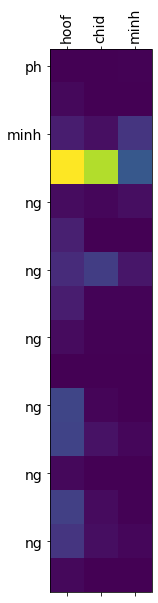

In [83]:
translate(u'hoof chid minh', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)